In [2]:
from datasets import load_dataset
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import requests

## Fetch Dataset

In [27]:
# dataset_hf = load_dataset("maharshipandya/spotify-tracks-dataset") # TODO: investigate the difference between this and the csv file
dataset = pd.read_csv('spotify-tracks-dataset.csv')

# convert dataset to pandas dataframe
# dataset = pd.DataFrame(dataset_hf['train'])

# copy the dataset
data = dataset.copy()

# get genres
genres = data['track_genre'].unique()
genres

# format genres to be searchable by keywords
genres_searchable = []

for genre in genres:
    if '-' in genre:
        genres_searchable.append(genre.split('-'))
    else:
        genres_searchable.append([genre])
genres_searchable
        


[['acoustic'],
 ['afrobeat'],
 ['alt', 'rock'],
 ['alternative'],
 ['ambient'],
 ['anime'],
 ['black', 'metal'],
 ['bluegrass'],
 ['blues'],
 ['brazil'],
 ['breakbeat'],
 ['british'],
 ['cantopop'],
 ['chicago', 'house'],
 ['children'],
 ['chill'],
 ['classical'],
 ['club'],
 ['comedy'],
 ['country'],
 ['dance'],
 ['dancehall'],
 ['death', 'metal'],
 ['deep', 'house'],
 ['detroit', 'techno'],
 ['disco'],
 ['disney'],
 ['drum', 'and', 'bass'],
 ['dub'],
 ['dubstep'],
 ['edm'],
 ['electro'],
 ['electronic'],
 ['emo'],
 ['folk'],
 ['forro'],
 ['french'],
 ['funk'],
 ['garage'],
 ['german'],
 ['gospel'],
 ['goth'],
 ['grindcore'],
 ['groove'],
 ['grunge'],
 ['guitar'],
 ['happy'],
 ['hard', 'rock'],
 ['hardcore'],
 ['hardstyle'],
 ['heavy', 'metal'],
 ['hip', 'hop'],
 ['honky', 'tonk'],
 ['house'],
 ['idm'],
 ['indian'],
 ['indie', 'pop'],
 ['indie'],
 ['industrial'],
 ['iranian'],
 ['j', 'dance'],
 ['j', 'idol'],
 ['j', 'pop'],
 ['j', 'rock'],
 ['jazz'],
 ['k', 'pop'],
 ['kids'],
 ['latin

## Authenticate to Spotify API

In [28]:
# load environment variables from .env file
from dotenv import load_dotenv
import os
load_dotenv()

# auth spotify api
client_id = os.getenv('SPOTIFY_CLIENT_ID')
client_secret = os.getenv('SPOTIFY_CLIENT_SECRET')
auth_cmd = f"curl -X POST 'https://accounts.spotify.com/api/token' \
     -H 'Content-Type: application/x-www-form-urlencoded' \
     -d 'grant_type=client_credentials&client_id={client_id}&client_secret={client_secret}'"

! {auth_cmd} > token.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   293  100   174  100   119    844    577 --:--:-- --:--:-- --:--:--  1422


In [29]:
with open('token.json', 'r') as file:
    token_json = file.read()
    token = token_json.split('"')[3]
    token_type = token_json.split('"')[7]

## Define Track/Song (via API)

In [30]:
# test track audio features
track_id = '3SktMqZmo3M9zbB7oKMIF7'
aud_features_url = "https://api.spotify.com/v1/audio-features/"

aud_features_json = requests.get(aud_features_url + track_id, headers={'Authorization': f'{token_type} {token}'}).json()

In [31]:
# url to get user's saved tracks
user_saved_tracks_url = 'https://api.spotify.com/v1/me/tracks'

user_saved_tracks_json = requests.get(user_saved_tracks_url, headers={'Authorization': f'{token_type} {token}'}).json()
user_saved_tracks_json

{'error': {'status': 401, 'message': 'Valid user authentication required'}}

In [32]:
# test get track
track_url = "https://api.spotify.com/v1/tracks/"

# get track json data
track_json = requests.get(track_url + track_id, headers={'Authorization': f'{token_type} {token}'}).json()

# extract track artists and name
track_artists_list = [artist['name'] for artist in track_json['artists']]
track_artists_str = ', '.join(track_artists_list)
track_name = track_json['name']
artist_id = track_json['artists'][0]['id']
track_name, track_artists_str

('Gravity', 'John Mayer')

## Fetch Track Artist's Genres

In [33]:
artist_url = "https://api.spotify.com/v1/artists/"

# get album json data
artist_json = requests.get(artist_url + artist_id, headers={'Authorization': f'{token_type} {token}'}).json()
artist_genres = artist_json['genres']
# artist_genres

# combine genres into one string
# artist_genres_str = ' '.join(artist_genres)
# print(artist_genres_str)

# separate words in artist genres
artist_genres_words = [genre.split() for genre in artist_genres]

# flatten list
artist_genres_words = list(set([word for genre in artist_genres_words for word in genre]))

artist_genres_words

# print genres that are in the dataset
genre_response = 'GENRES IN DATASET & ASSOCIATED W/ TRACK ARTIST: '
for word in artist_genres_words:
    if word in genres:
        genre_response += '\n' + word
print(genre_response)

GENRES IN DATASET & ASSOCIATED W/ TRACK ARTIST: 
singer-songwriter


## Drop & Move Columns

In [34]:
# unnecessary columns
cols_to_drop = ['Unnamed: 0', 'album_name',
                'loudness', 'explicit', 'time_signature',
                'instrumentalness', 'duration_ms', 'mode', 'valence']

dataset.drop(cols_to_drop, axis=1, inplace=True)

# drop duplicates (tracks with the same track_id)
# keep the first occurrence
dataset.drop_duplicates(subset='track_id', keep='first', inplace=True)

# move track_name to the first column
track_name_col = dataset['track_name']
dataset.drop(labels=['track_name'], axis=1, inplace=True)
dataset.insert(0, 'track_name', track_name_col)

# move artist_name to the second column
artist_name_col = dataset['artists']
dataset.drop(labels=['artists'], axis=1, inplace=True)
dataset.insert(1, 'artists', artist_name_col)

# move genre to the third column
genre_col = dataset['track_genre']
dataset.drop(labels=['track_genre'], axis=1, inplace=True)
dataset.insert(2, 'track_genre', genre_col)

# move track_id to the 2nd column
track_id_col = dataset['track_id']
dataset.drop(labels=['track_id'], axis=1, inplace=True)
dataset.insert(3, 'track_id', track_id_col)

# print first 5 rows
dataset.head()

,track_name,artists,track_genre,track_id,popularity,danceability,energy,key,speechiness,acousticness,liveness,tempo
0,Comedy,Gen Hoshino,acoustic,5SuOikwiRyPMVoIQDJUgSV,73,0.676,0.4610,1,0.1430,0.0322,0.3580,87.917
1,Ghost - Acoustic,Ben Woodward,acoustic,4qPNDBW1i3p13qLCt0Ki3A,55,0.420,0.1660,1,0.0763,0.9240,0.1010,77.489
2,To Begin Again,Ingrid Michaelson;ZAYN,acoustic,1iJBSr7s7jYXzM8EGcbK5b,57,0.438,0.3590,0,0.0557,0.2100,0.1170,76.332
3,Can't Help Falling In Love,Kina Grannis,acoustic,6lfxq3CG4xtTiEg7opyCyx,71,0.266,0.0596,0,0.0363,0.9050,0.1320,181.740
4,Hold On,Chord Overstreet,acoustic,5vjLSffimiIP26QG5WcN2K,82,0.618,0.4430,2,0.0526,0.4690,0.0829,119.949


## Scale Features

In [35]:
# feature scale the data (except first column)
scaler = StandardScaler()

# turn data into float type
dataset.iloc[:, 4:] = dataset.iloc[:, 4:].values.astype(float)

# feature scale the data (except label-encoded data)
dataset.iloc[:, 4:] = scaler.fit_transform(dataset.iloc[:, 4:])

/var/folders/b6/6366288j429498w43rvsw48w0000gn/T/ipykernel_68766/61435344.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.93392568  1.05932026  1.15649864 ... -0.54412302  0.37907159
 -0.54412302]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.iloc[:, 4:] = scaler.fit_transform(dataset.iloc[:, 4:])
/var/folders/b6/6366288j429498w43rvsw48w0000gn/T/ipykernel_68766/61435344.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.20328584 -1.20328584 -1.48419444 ... -1.48419444  0.48216576
 -1.20328584]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.iloc[:, 4:] = scaler.fit_transform(dataset.iloc[:, 4:])


In [16]:
# # create heatmap
# plt.figure(figsize = (10, 10))
# sns.heatmap(dataset.iloc[:, 1:].corr(), annot = True, cmap = 'coolwarm', linewidths = 0.5)
# plt.show()

# # histogram
# dataset.hist(figsize=(12, 8), bins=20)
# plt.tight_layout()
# plt.show()

## Dimensionality Reduction (PCA)

In [36]:
# run pca to reduce the number of features to 2
pca = PCA(n_components=2)
data_pca = pca.fit_transform(dataset.iloc[:, 4:])

# print columns in PCA
feature_names = dataset.columns[4:]
print('Features to include in PCA:\n', feature_names)

Features to include in PCA:
 Index(['popularity', 'danceability', 'energy', 'key', 'speechiness',
       'acousticness', 'liveness', 'tempo'],
      dtype='object')


In [19]:
# run t-SNE to reduce the number of features to 2
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, random_state=42)
# data_pca = tsne.fit_transform(dataset.iloc[:, 3:])

## Fit K-Means to Data

In [37]:
# create kmeans++ model
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init='auto', random_state=0)
pred_y = kmeans.fit_predict(data_pca)

## Perform Elbow-Method for Optimal k

In [38]:
# range of k values to test
k_vals = range(1, 13)

# list to store within-cluster sum of squares (wcss) values for each k
wcss_vals = []

# compute wcss for each k
for k in k_vals:
    # init kmeans w/ k clusters
    kmeans_test = KMeans(n_clusters=k, init='k-means++', random_state=0)
    kmeans_test.fit(data_pca)

    # append wcss to list
    wcss_vals.append(kmeans_test.inertia_)

print(wcss_vals)

[287360.21803457284, 159902.30138671276, 101781.5364951991, 81925.89541376034, 60775.669741353166, 50388.59128517052, 43756.604826198134, 36904.34969853952, 32829.423795006325, 30332.54986296974, 27354.656611299084, 25105.525559433172]


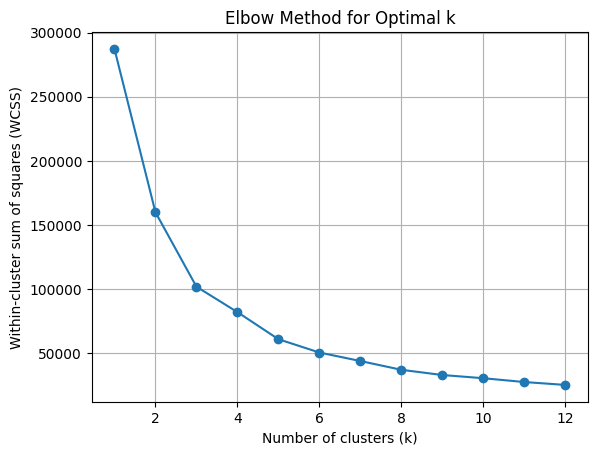

In [39]:
plt.plot(k_vals, wcss_vals, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.xticks
plt.grid(True)
plt.show()

In [23]:
# print the silhouette score
# print(silhouette_score(data_pca, pred_y))

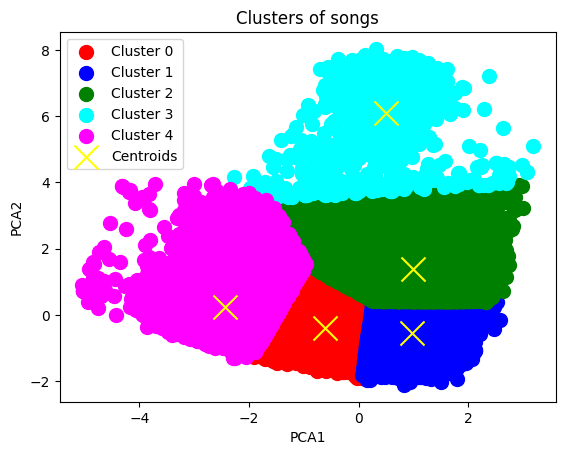

In [40]:
# plot the clusters
plt.scatter(data_pca[pred_y == 0, 0], data_pca[pred_y == 0, 1], s=100, c='red', label='Cluster 0')
plt.scatter(data_pca[pred_y == 1, 0], data_pca[pred_y == 1, 1], s=100, c='blue', label='Cluster 1')
plt.scatter(data_pca[pred_y == 2, 0], data_pca[pred_y == 2, 1], s=100, c='green', label='Cluster 2')
plt.scatter(data_pca[pred_y == 3, 0], data_pca[pred_y == 3, 1], s=100, c='cyan', label='Cluster 3')
plt.scatter(data_pca[pred_y == 4, 0], data_pca[pred_y == 4, 1], s=100, c='magenta', label='Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label='Centroids', marker='x')
plt.title('Clusters of songs')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

In [25]:
# histogram
# playlist_0.hist(figsize=(12, 8), bins=20)
# plt.tight_layout()
# plt.show()

## Sort Dataset by Cluster & Distance-to-Cluster

In [41]:
# add a column to the dataset for the cluster number and distance from the centroid
dataset['cluster'] = pred_y
dataset['distance'] = kmeans.fit_transform(data_pca).min(axis=1)

# sort the dataset by cluster and distance
dataset = dataset.sort_values(by=['cluster', 'distance'])

# print the first 10 rows
dataset.head(10)

,track_name,artists,track_genre,track_id,popularity,danceability,energy,key,speechiness,acousticness,liveness,tempo,cluster,distance
11053,Kiss from a Rose,Seal,british,3YKptz29AsOlm7WAVnztBh,1.982515,0.123574,-0.395388,1.324892,-0.502682,1.051407,0.456840,0.321631,0,0.001717
54154,isle of the blest,tstewart;Machinedrum,idm,3jW0pK6SS8vH2wKLjlBLBm,0.233304,-0.866860,-0.056343,1.605800,-0.477964,0.906574,-0.492446,0.596024,0,0.009649
56650,Hrs & Hrs,Muni Long,indie-pop,3M5azWqeZbfoVkGXygatlb,2.128282,-0.221663,-0.442152,0.201257,0.631711,0.823811,-0.564284,0.394944,0,0.011405
84801,An American Prayer,Jim Morrison;The Doors,psych-rock,2VDkE9sdVpQAgEqH5fvTMV,0.573428,0.802729,-0.808476,0.482166,-0.236960,0.244476,0.082257,-0.387461,0,0.012702
97597,Um Degrau Na Escada,Chico Rey & Paraná,sertanejo,5Pn6spaFtc1kEk2HI86SaW,0.573428,-0.012257,-0.130387,-0.360560,-0.543291,0.906574,-0.107600,0.404142,0,0.016436
94794,Walking Through The Rain,SadBoyProlific;Iriasona,sad,03Nx63Qf5HnqGF3KkGIJ6l,0.913553,0.282044,-1.050094,0.482166,0.684679,1.054363,-0.595072,1.795797,0,0.018445
8735,Casa Con Diez Pinos,Manal,blues,2Ras7UcXvzenVmkyVMibdh,0.087536,-0.193365,-0.278476,-0.922377,-0.409988,1.116435,-0.348770,1.538803,0,0.018461
40466,Tu És Meu Socorro,Marcos Freire,gospel,7ehQuGJjYtcJ03dlA8uK3B,0.379072,-0.295238,-0.321344,-0.922377,-0.507979,-0.287566,-0.297458,-1.069194,0,0.018643
20127,Love Me More,Sam Smith,dance,4gVEvqKXRFe2WarhQxMzjP,-1.467318,1.295116,-0.761712,1.324892,-0.202531,-0.077705,-0.466790,-1.230331,0,0.018941
41286,Just Plain Bad,Angry Johnny and the Killbillies,goth,3TUIbBibx1RMF67PdrN2Bm,-0.301177,-0.855541,-0.851344,1.043983,-0.381739,-0.835570,-0.548890,-0.952517,0,0.019270


# Song Recommendations

In [46]:
# search for song's full data using the track_id
song_matches = dataset[dataset['track_id'] == track_id]
print(song_matches)

# get the first occurrence
full_given_song = song_matches.loc[song_matches.first_valid_index()]

# save the numerical data in a separate variable
given_song = full_given_song[4:].astype(float)

# print the full given song data
print(f"DATA FROM: {track_name} by {track_artists_str}")
given_song

      track_name     artists        track_genre                track_id  \
99261    Gravity  John Mayer  singer-songwriter  3SktMqZmo3M9zbB7oKMIF7   

       popularity  danceability    energy       key  speechiness  \
99261    1.885336      1.080051 -1.202079  0.482166    -0.470019   

       acousticness  liveness     tempo  cluster  distance  
99261      1.190329  0.118176  0.057797        0  0.730713  
DATA FROM: Gravity by John Mayer


popularity      1.885336
danceability    1.080051
energy         -1.202079
key             0.482166
speechiness    -0.470019
acousticness    1.190329
liveness        0.118176
tempo           0.057797
cluster         0.000000
distance        0.730713
Name: 99261, dtype: float64

In [28]:
# consider ensemble clustering by running dbscan on each cluster to find subclusters

## Initial Cluster Points & Filtering

In [43]:
# find the closest centroid

# get the index of the closest centroid
closest_centroid_idx = int(given_song['cluster'])

# get the coordinates of the closest centroid
closest_centroid = kmeans.cluster_centers_[closest_centroid_idx]

# Find data points belonging to the closest cluster
cluster_points = dataset.iloc[:, :][kmeans.labels_ == closest_centroid_idx]

# Remove the given song from the closest cluster if it exists
cluster_points = cluster_points[cluster_points['track_name'] != full_given_song['track_name']]

# Only consider songs of the same genre
# TODO: create clusters of genres that are similar and only from that cluster
cluster_points = cluster_points[cluster_points['track_genre'] == full_given_song['track_genre']]

# print the amount of songs filtered
print(cluster_points.shape)

cluster_points.head(10)

(130, 14)


,track_name,artists,track_genre,track_id,popularity,danceability,energy,key,speechiness,acousticness,liveness,tempo,cluster,distance
99364,Someone New,Hozier,singer-songwriter,22sS7JkzeVeq4vOPCB6Fbj,1.642391,0.174511,-0.372005,0.482166,-0.463839,0.232653,0.354214,-0.998703,0,0.056481
99913,Tui Ki Kore Dili,Anupam Roy,singer-songwriter,3tCexBo7fH5BspYwQ0mr1g,-0.009642,1.130987,-0.481123,1.324892,-0.500916,0.608039,0.077126,-0.204643,0,0.146212
99958,Lamhe Zaroori,Neyhal,singer-songwriter,6hkLuLZ3x5hb5Vr3mbScZF,-0.155409,0.429194,0.091745,1.324892,-0.526517,0.729226,-0.554021,-0.731084,0,0.200474
99572,Angel Of Small Death & The Codeine Scene,Hozier,singer-songwriter,1SCXzqKZdif5b33POmzwI4,1.399445,-1.047968,0.013804,-0.360560,-0.290811,-0.340770,-0.497577,-0.976656,0,0.238150
99747,Jag har väntat på ett regn,Lars Winnerbäck,singer-songwriter,1iIk4Q10fffmVs3WPvDfxU,-1.613085,-0.521623,-0.527888,-1.203286,-0.447949,-0.606791,-0.554021,-0.519578,0,0.286832
99668,KEEP IT TO YOURSELF,Clinton Kane,singer-songwriter,6UcfBPUiBB7ZeQQkwZ8OF5,1.350855,-0.391452,-0.107005,-1.484194,-0.294342,0.912485,-0.640740,0.337170,0,0.320994
99961,Jaago Uma,Anupam Roy;Rupankar Bagchi,singer-songwriter,6HoxQTzbgOilzBMZEYqGw4,-0.009642,-1.630909,-0.114799,-0.922377,-0.424996,1.134169,-0.718222,1.501383,0,0.333970
99604,Woh Purana Pyar,Suzonn,singer-songwriter,7977HqRRgSuVc9hzJFJvmE,0.087536,-0.397111,-0.711050,-0.079651,-0.524752,0.197184,-0.482184,-0.398419,0,0.348639
99179,Fingers Crossed,Lauren Spencer Smith,singer-songwriter,3yMC1KsTwh0ceXdIe4QQAQ,2.322639,-0.012257,-0.629211,-0.079651,-0.301405,0.856325,0.477365,-0.419835,0,0.390827
99018,Numb Little Bug,Em Beihold,singer-songwriter,3o9kpgkIcffx0iSwxhuNI2,2.176872,1.017795,-0.418770,0.763074,-0.093065,-0.003810,0.169489,-1.231327,0,0.415222


In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

# get all distances of data points in the cluster from the given song
distances = euclidean_distances([given_song.iloc[:8]], cluster_points.iloc[:, 4:12]) # 4:12 are the numerical features

# get the indices of the 10 closest songs
closest_songs_indices = distances.argsort()[0][:10]

# get the 10 closest songs
closest_songs = cluster_points.iloc[closest_songs_indices]

# print the 10 closest songs
closest_songs

,track_name,artists,track_genre,track_id,popularity,danceability,energy,key,speechiness,acousticness,liveness,tempo,cluster,distance
99186,Unloving You,Anson Seabra,singer-songwriter,2w9nvs1ByWUGkED4M0ug34,1.690980,1.147966,-0.940976,0.201257,-0.497385,0.900662,-0.384689,-0.004958,0,0.853421
99511,It's You,Sezairi,singer-songwriter,7rdnB5DAyPbaj51TCQRcqW,1.933926,0.383917,-0.695461,0.763074,-0.492088,0.640552,-0.528365,0.526496,0,0.827391
99962,Love on the Weekend,John Mayer,singer-songwriter,0j2WBxWZnWti5TpSxjJvPb,1.350855,0.944220,-0.344726,0.482166,-0.520338,0.646464,-0.779284,-0.070302,0,0.943345
99619,Superhero,Hayd,singer-songwriter,4NXROG27qc3PGsf6IK5MOD,1.253677,0.361278,-1.985389,1.043983,-0.315529,1.621875,0.692879,-0.071431,4,0.415895
99027,Head In The Clouds,Hayd,singer-songwriter,3CeKc83EsgRPItgvlDHo5B,1.836747,1.221541,-1.950315,-0.360560,-0.325240,1.887896,-0.633043,-0.198567,4,1.374931
99179,Fingers Crossed,Lauren Spencer Smith,singer-songwriter,3yMC1KsTwh0ceXdIe4QQAQ,2.322639,-0.012257,-0.629211,-0.079651,-0.301405,0.856325,0.477365,-0.419835,0,0.390827
99708,Suffocate,Hayd,singer-songwriter,1ydKLmtx7LYnDe1udTu96w,1.205088,0.514088,-2.244933,-0.360560,-0.381739,1.533201,-0.215357,-0.000044,4,0.857505
99577,Some Days,Brent Morgan,singer-songwriter,6vfZSkjmzjo6q5BhkWSRxY,1.205088,0.038680,-1.537227,0.201257,-0.514158,1.636654,-0.700263,0.595759,4,1.278222
99460,the same,mehro,singer-songwriter,03OjIsSVv8mwp58p3iK87o,1.448034,0.117914,-0.508402,-0.079651,-0.514158,1.571626,-0.584809,0.729967,0,0.744518
99353,Mayonaka No Door / Stay With Me,Chris Andrian Yang,singer-songwriter,6EgwlXnFrfkFqOKqY3dqki,1.205088,1.080051,-2.148286,1.043983,-0.370263,1.459306,-0.697184,-0.735533,4,1.328646


/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklear

PCA of Given Song: [[ 0.73044973 -0.89992016]]
PCA of Cluster Points (10 songs): [[-0.50421116 -0.48503669]
 [-0.67260423 -0.23054013]
 [-0.54781058 -0.18266189]
 [-0.34585617 -0.47673292]
 [-0.7345779  -0.00653771]
 [-0.7345779  -0.00653771]
 [-0.59406686  0.0185069 ]
 [-0.59406686  0.0185069 ]
 [-0.59447927 -0.83520673]
 [-0.73660832  0.00547198]]


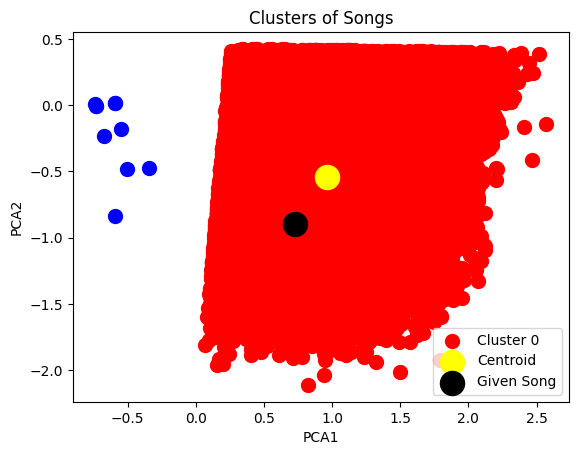

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Transform the given song into PCA space
given_song_pca = pca.transform([given_song.iloc[:8].astype(float)])
print("PCA of Given Song:", given_song_pca)

# Calculate PCA-transformed vectors for the first 10 cluster songs
ten_songs_pca = []

for i in range(10):
    # Convert to float and reshape to match PCA input requirements
    song_features = cluster_points.iloc[i, 4:12].astype(float).to_numpy()
    song_pca = pca.transform([song_features])
    ten_songs_pca.append(song_pca[0])  # Append the flattened PCA result

# Convert to a numpy array for easier manipulation
ten_songs_pca = np.array(ten_songs_pca)
print("PCA of Cluster Points (10 songs):", ten_songs_pca)

# Plot the cluster points in PCA space
plt.scatter(
    data_pca[pred_y == closest_centroid_idx, 0], 
    data_pca[pred_y == closest_centroid_idx, 1], 
    s=100, c='red', label='Cluster 0'
)

# Plot the centroid
plt.scatter(
    closest_centroid[0], closest_centroid[1], 
    s=300, c='yellow', label='Centroid'
)

# Plot the given song
plt.scatter(
    given_song_pca[0][0], given_song_pca[0][1], 
    s=300, c='black', label='Given Song'
)

# Plot the first 10 songs from the cluster
for i, song_pca in enumerate(ten_songs_pca):
    plt.scatter(song_pca[0], song_pca[1], s=100, c='blue')

# Add titles and labels
plt.title('Clusters of Songs')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import pairwise_distances_argmin_min
import pandas as pd

# Step 1: Compute distances between given song and all songs in PCA space
indices, distances = pairwise_distances_argmin_min(given_song_pca, ten_songs_pca)

# Step 2: Sort by distance and get the 10 closest songs
sorted_indices = distances.argsort()[:10]

# Step 3: Retrieve and decrypt the PCA features of the closest songs
closest_songs_pca = ten_songs_pca[sorted_indices]
closest_songs_original = pca.inverse_transform(closest_songs_pca)

# Step 4: Construct a new DataFrame with decrypted data and metadata
# Add metadata like song names and genres from `cluster_points`
closest_songs_metadata = cluster_points.iloc[sorted_indices][['track_name', 'track_genre']].reset_index(drop=True)

# Combine metadata with decrypted features into a new DataFrame
columns = feature_names.to_list()
closest_songs_features_df = pd.DataFrame(closest_songs_original, columns=columns)

# Final DataFrame
output_df = pd.concat([closest_songs_metadata, closest_songs_features_df], axis=1)

# Display the DataFrame
output_df.head(10)

# Save to a CSV file if needed
# output_df.to_csv('closest_songs.csv', index=False)


,track_name,track_genre,popularity,danceability,energy,key,speechiness,acousticness,liveness,tempo
0,SAD GIRLZ LUV MONEY - Remix,alternative,0.098816,0.029998,-0.34702,-0.019327,-0.354958,0.226192,-0.411505,-0.107397


## 

In [41]:
cluster_points.iloc[i, 4:12]

popularity     -1.613085
danceability     0.94422
energy         -0.325241
key            -1.484194
speechiness    -0.277569
acousticness    0.797209
liveness       -0.210226
tempo           0.065932
Name: 3369, dtype: object

[[ 0.73044973 -0.89992016]]
[[-0.50421116 -0.48503669]
 [-0.67260423 -0.23054013]
 [-0.54781058 -0.18266189]
 [-0.34585617 -0.47673292]
 [-0.7345779  -0.00653771]
 [-0.7345779  -0.00653771]
 [-0.59406686  0.0185069 ]
 [-0.59406686  0.0185069 ]
 [-0.59447927 -0.83520673]
 [-0.73660832  0.00547198]]


/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklear

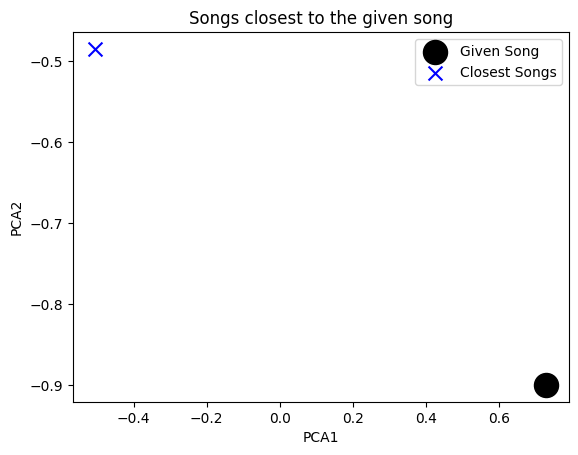

In [45]:
from sklearn.metrics import pairwise_distances_argmin_min

# get the pca-version of the given song
given_song_pca = pca.transform([given_song.iloc[:8]]) # exclude the cluster and distance columns
print(given_song_pca)
# calculate distances from the given song to all songs in the cluster
ten_songs_pca = []

# calculate PCA-transformed vectors for the first 10 cluster songs
for i in range(10):
    # convert to float, reshape to match PCA input requirements, and transform to PCA space
    cluster_points_pca = pca.transform([cluster_points.iloc[i, 4:12].astype(float)])

    # append the flattened PCA result
    ten_songs_pca.append(cluster_points_pca[0])
ten_songs_pca = np.array(ten_songs_pca)
print(ten_songs_pca)
indices, distances = pairwise_distances_argmin_min(given_song_pca, ten_songs_pca)

# get indices of the 10 closest songs
closest_songs_indices = distances.argsort()[:10]

# plot the given song
plt.scatter(given_song_pca[0][0], given_song_pca[0][1], s=300, c='black', label='Given Song')

# plot the first 10 songs closest to the given song
for idx in closest_songs_indices:
    song_pca = ten_songs_pca[idx]
    plt.scatter(song_pca[0], song_pca[1], s=100, c='blue', label='Closest Songs', marker='x')

plt.title('Songs closest to the given song')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklear

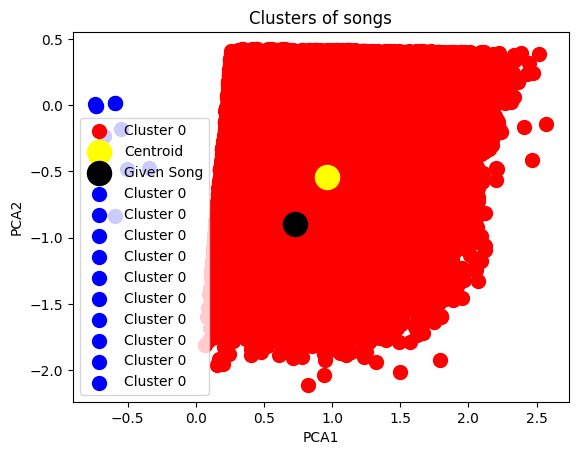

In [35]:
# Plot the cluster points
plt.scatter(data_pca[pred_y == closest_centroid_idx, 0], data_pca[pred_y == closest_centroid_idx, 1], s=100, c='red', label='Cluster 0')
plt.scatter(closest_centroid[0], closest_centroid[1], s=300, c='yellow', label='Centroid')

# get the pca-version of the given song
given_song_pca = pca.transform([given_song.iloc[:8]])

# plot the given song
plt.scatter(given_song_pca[0][0], given_song_pca[0][1], s=300, c='black', label='Given Song')

# plot the first 10 songs (iterate thru cluster_points)
for i in range(10):
    song_pca = pca.transform([cluster_points.iloc[i, 4:12]]) # view this line
    plt.scatter(song_pca[0][0], song_pca[0][1], s=100, c='blue', label='Cluster 0')

plt.title('Clusters of songs')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

In [36]:
# Get the genre words from the given song
song_genre_words = full_given_song['track_genre'].split()
song_genre_words = ' '.join(song_genre_words)

# remove '-' from genre words
if '-' in song_genre_words:
    # split the genre into words
    song_genre_words = song_genre_words.split('-')

# join all words that exist in both lists
genre_words = [word for word in song_genre_words if word in artist_genres_words]
# genre_words = ' '.join(genre_words)

# join all genres similar to genre words
for genre in genres_searchable:
    if any(word in genre for word in genre_words):

        # turn genre back into hyphenated string
        if len(genre) > 1:
            genre = '-'.join(genre)
        else:
            genre = genre[0]

        # keep only unique genres
        if genre not in genre_words:
            genre_words.append(genre)

# print(genre_words)

# Compare genre words between the given song and the closest cluster points
cluster_points = cluster_points[cluster_points['track_genre'].isin(genre_words)]

# print(song_genre_words)
# cluster_points = cluster_points[cluster_points['track_genre'] in artist_genres_words]

# Only keep one song per artist
cluster_points = cluster_points.drop_duplicates(subset='artists')

# Get songs with a similar given attribute
attributes = ['speechiness', 'popularity', 'danceability', 'energy', 'acousticness', 'liveness', 'tempo']
sensitivity = 1

for attribute in attributes:
    cluster_points = cluster_points[
        (cluster_points[attribute] >= full_given_song[attribute] - sensitivity) & (
                cluster_points[attribute] <= full_given_song[attribute] + sensitivity)]

print("\nFOUND", len(cluster_points), "SIMILAR SONGS\n")

print(full_given_song[:3])
# print(data.iloc[song_idx, :])


FOUND 0 SIMILAR SONGS

track_name                Odd Look
artists        Kavinsky;The Weeknd
track_genre            alternative
Name: 3751, dtype: object


In [37]:
# given a song, find the most similar song in the same cluster
from sklearn.metrics.pairwise import euclidean_distances

# find the 2nd closest song
distances = euclidean_distances(cluster_points.iloc[:, 3:], [given_song])

closest_song_indices = distances.flatten().argsort()

second_closest_song_idx = closest_song_indices[1:10]
print("Given song: \"" + full_given_song[:3]['track_name'] + "\" by", full_given_song[:3]['artists'], "| Genre:", full_given_song[:3]['track_genre'])
print("\nSong Recommendations:")
print("=====================================")

pd.set_option('display.width', 1000)
recommendations = cluster_points.iloc[second_closest_song_idx, :3]
print(recommendations)

ValueError: Found array with 0 sample(s) (shape=(0, 11)) while a minimum of 1 is required by check_pairwise_arrays.

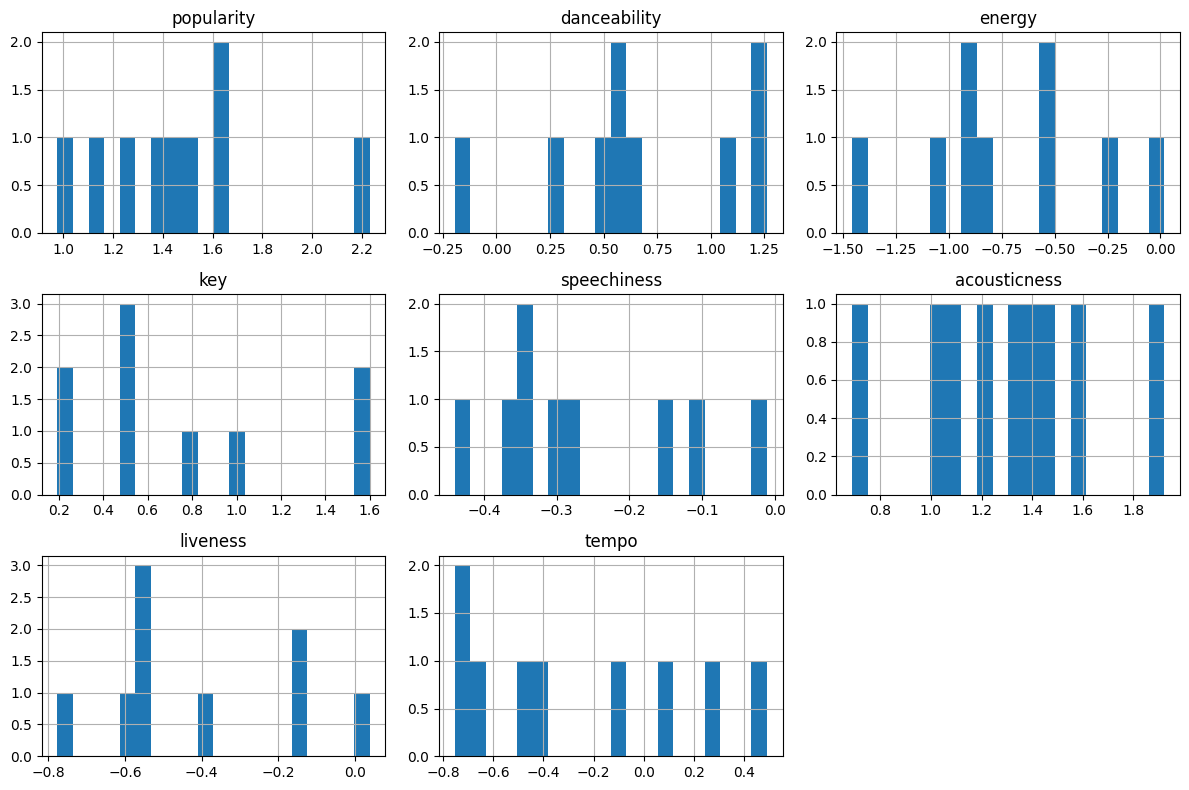

In [ ]:
# plot histogram of the recommendations pd dataframe
recs = cluster_points.iloc[second_closest_song_idx]
recs.hist(figsize=(12, 8), bins=20)
# label x-axis with song names
plt.xticks(rotation=45)
plt.xlabel('track_name')
plt.tight_layout()
plt.show()

In [ ]:
# Filter only songs from the same genre
cluster_points = cluster_points[dataset['track_genre'] == dataset.iloc[song_idx, 2]]

In [ ]:
# Calculate distances
distances = euclidean_distances([given_song], cluster_points)

# Get indices of K closest data points
k_closest_indices = distances.argsort(axis=1)[0][:4]

# # Get K closest data points
k_closest_points = cluster_points.iloc[k_closest_indices]

# query the dataset for the closest songs based on the indices
closest_songs = dataset.iloc[k_closest_indices]
# print(closest_songs)